<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/test_clip_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=afc535299c78d22bbe34d45dc7158daa2bad385e28308d6278620ac08f509f18
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5

In [12]:
import open_clip
import clip
from torchvision.datasets import CIFAR10, CIFAR100, ImageNet
from open_clip import tokenizer
import torch
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
import nltk
nltk.download("punkt")
from nltk.tokenize import WordPunctTokenizer
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello, World!' + color.END)

Hello, World!


In [5]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 351M/351M [00:02<00:00, 135MiB/s]


Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [5]:
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

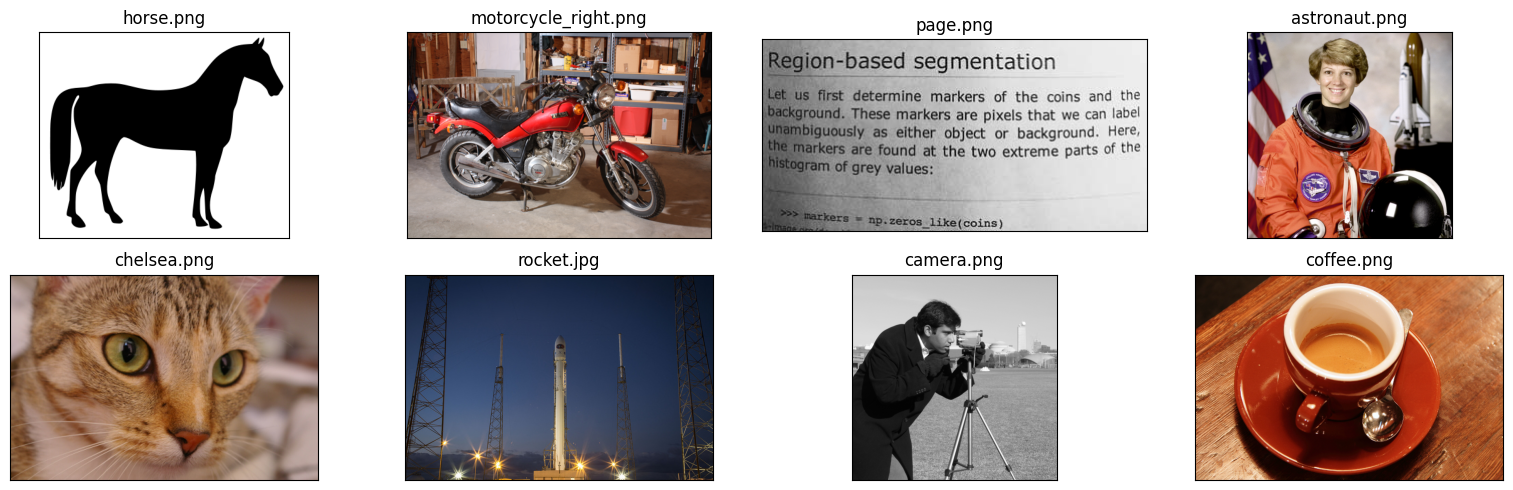

In [6]:
import skimage

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
plt.tight_layout()

In [ ]:
images[:2]

In [ ]:
image_input

In [13]:
from torch.nn import functional as F

image_input = torch.tensor(np.stack(images))
image_encodings = clip_model.encode_image(image_input)
image_encodings = F.normalize(image_encodings)

In [14]:
image_encodings

tensor([[-0.0130, -0.0791,  0.0620,  ..., -0.0313,  0.0424, -0.0008],
        [-0.0089, -0.0020,  0.0395,  ..., -0.0087,  0.0473,  0.0282],
        [-0.0367, -0.0760,  0.0343,  ...,  0.0113,  0.0028,  0.0622],
        ...,
        [-0.0316, -0.0848, -0.0333,  ...,  0.0007,  0.0410,  0.0333],
        [-0.0091, -0.0517, -0.0254,  ..., -0.0209,  0.0355, -0.0054],
        [ 0.0244, -0.0820,  0.0135,  ..., -0.0233, -0.0066,  0.0203]],
       grad_fn=<DivBackward0>)

In [26]:
label_encodings = F.normalize(clip_model.encode_text(tokenizer.tokenize(descriptions)))

In [28]:
image_labels_similarity = image_encodings @ label_encodings.T

In [29]:
image_labels_similarity

tensor([[0.2247, 0.2250, 0.1948, 0.1993, 0.1940, 0.1976, 0.3094, 0.1970],
        [0.1983, 0.1851, 0.1678, 0.2200, 0.2574, 0.1701, 0.1854, 0.1621],
        [0.2291, 0.1673, 0.1416, 0.1695, 0.1720, 0.2020, 0.1840, 0.1661],
        [0.1951, 0.1860, 0.2651, 0.2026, 0.1861, 0.1785, 0.1681, 0.1452],
        [0.2255, 0.2201, 0.1922, 0.2257, 0.1859, 0.2309, 0.2030, 0.2037],
        [0.1808, 0.1564, 0.2100, 0.2468, 0.1444, 0.1802, 0.1691, 0.1411],
        [0.1837, 0.1866, 0.1819, 0.2000, 0.1903, 0.2621, 0.1775, 0.1680],
        [0.1878, 0.1912, 0.1532, 0.1678, 0.1721, 0.1832, 0.1712, 0.2709]],
       grad_fn=<MmBackward0>)

In [31]:
clip_predictions = image_labels_similarity.argmax(dim=1)
clip_predictions

tensor([6, 4, 0, 2, 5, 3, 5, 7])

In [34]:
n_classes = len(descriptions)
image_description_similarity = [None]*n_classes
image_description_similarity_cumulative = [None]*n_classes

In [43]:
for i, (k, v) in enumerate(descriptions.items()):
        v = F.normalize(clip_model.encode_text(tokenizer.tokenize(v)))
        dot_product_matrix = image_encodings @ v.T
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

In [44]:
cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)

In [45]:
descr_predictions = cumulative_tensor.argmax(dim=1)

In [47]:
descr_predictions

tensor([6, 4, 0, 2, 1, 3, 5, 7])

In [21]:
def aggregate_similarity(similarity_matrix_chunk, aggregation_method='mean'):
    if aggregation_method == 'max': return similarity_matrix_chunk.max(dim=1)[0]
    elif aggregation_method == 'sum': return similarity_matrix_chunk.sum(dim=1)
    elif aggregation_method == 'mean': return similarity_matrix_chunk.mean(dim=1)
    else: raise ValueError("Unknown aggregate_similarity")

it works! now try to do this with another bunch of images

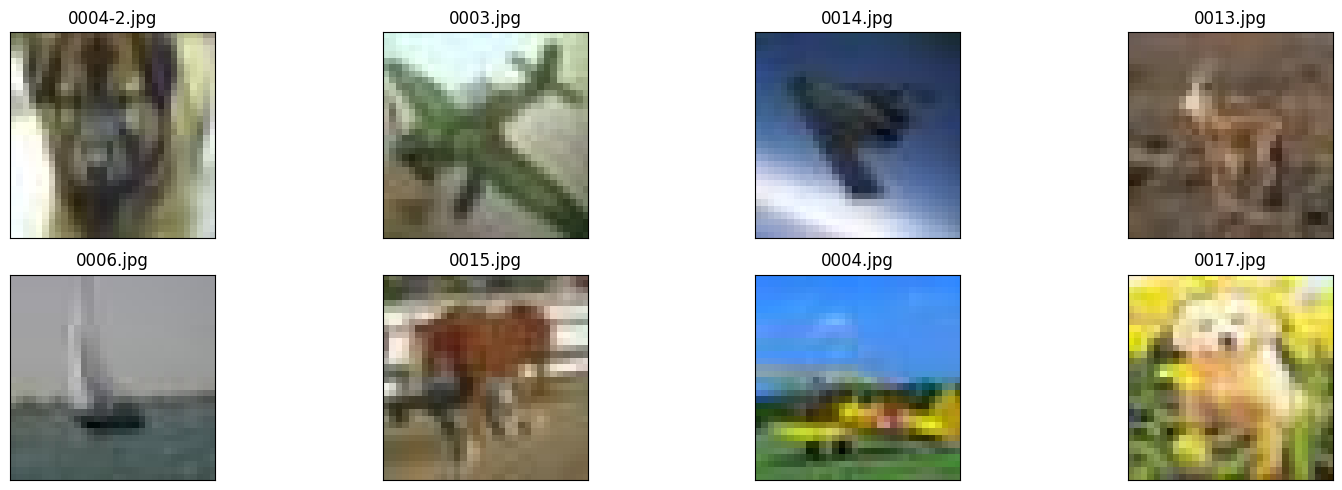

In [48]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [50]:
text_descriptions = []

with open("all_concepts.txt", "r") as file:
  for line in file:
    text_descriptions.append(line.strip())

print(text_descriptions)

['...shorts', '3', '3 inches in diameter', '4.5 billion years old', '84% water', '88 keys', 'a cd', 'a symphony', 'a bay', 'a blade', 'a book', 'a booth', 'a brain', 'a chapter', 'a cigarette', 'a container', 'a door', 'a face', 'a feather', 'a flame', 'a gentelman', 'a giraffe', 'a henhouse', 'a horn', 'a hump', 'a knive', 'a ledge', 'a leg', 'a living room', 'a miniature', 'a mirror', 'a needle', 'a neuron', 'a note', 'a number', 'a pie', 'a pitcher', 'a razor', 'a sole', 'a street', 'a tire', 'a tree is a plant, and', 'a trunk', 'a wagon', 'a wall', 'a wave', 'a window', 'a wooden floor', 'acadian', 'africa on the plains', 'african', 'afroasiatic', 'alabama', 'alaskan', 'alberta', 'aleutian islands', 'alexandria', 'algonquian', 'all bulls', 'all kings', 'altaic', 'american', 'amur', 'an antenna', 'an engine', 'an examination table', 'an index card', 'an outfit', 'an oven', 'an uncle', 'anaheim', 'antarctic ocean', 'antarctica', 'apalachicola', 'arafura sea', 'arctic archipelago', 'a

In [7]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

In [54]:
text_descriptions = remove_prefixes(text_descriptions)
print(text_descriptions)

['...shorts', '3', '3 inches in diameter', '4.5 billion years old', '84% water', '88 keys', 'cd', 'symphony', 'bay', 'blade', 'book', 'booth', 'brain', 'chapter', 'cigarette', 'container', 'door', 'face', 'feather', 'flame', 'gentelman', 'giraffe', 'henhouse', 'horn', 'hump', 'knive', 'ledge', 'leg', 'living room', 'miniature', 'mirror', 'needle', 'neuron', 'note', 'number', 'pie', 'pitcher', 'razor', 'sole', 'street', 'tire', 'tree is a plant, and', 'trunk', 'wagon', 'wall', 'wave', 'window', 'wooden floor', 'acadian', 'africa on the plains', 'african', 'afroasiatic', 'alabama', 'alaskan', 'alberta', 'aleutian islands', 'alexandria', 'algonquian', 'all bulls', 'all kings', 'altaic', 'american', 'amur', 'antenna', 'engine', 'examination table', 'index card', 'outfit', 'oven', 'uncle', 'anaheim', 'antarctic ocean', 'antarctica', 'apalachicola', 'arafura sea', 'arctic archipelago', 'arizona', 'arkansas', 'armed forces day', 'asia', 'asiatic', 'atlantic', 'atlases', 'austraila', 'australa

In [52]:
classes = []
with open("all_classes.txt", "r") as file:
  for line in file:
    classes.append(line.strip())

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'apple', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak tree', 'orange', 'orchid', 'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet pepper', 'table', 'tank', 'telephone', 'television', 't

In [55]:
image_input = torch.tensor(np.stack(images))
image_encodings = clip_model.encode_image(image_input)
image_encodings = F.normalize(image_encodings)

In [62]:
label_encodings = F.normalize(clip_model.encode_text(tokenizer.tokenize(classes[:10])))

In [63]:
image_labels_similarity = image_encodings @ label_encodings.T

In [69]:
image_labels_similarity.argmax(dim=1)

tensor([4, 0, 0, 4, 8, 7, 0, 5])

In [77]:
n_classes = len(classes[:10])
image_description_similarity = [None]*n_classes
image_description_similarity_cumulative = [None]*n_classes

In [78]:
for i, v in enumerate(classes[:10]):
        v = F.normalize(clip_model.encode_text(tokenizer.tokenize(v)))
        dot_product_matrix = image_encodings @ v.T
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

In [80]:
cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
predictions = cumulative_tensor.argmax(dim=1)

In [81]:
predictions

tensor([4, 0, 0, 4, 8, 7, 0, 5])

In [91]:
list_of_pred = torch.Tensor.tolist(predictions)
list_of_pred

[4, 0, 0, 4, 8, 7, 0, 5]

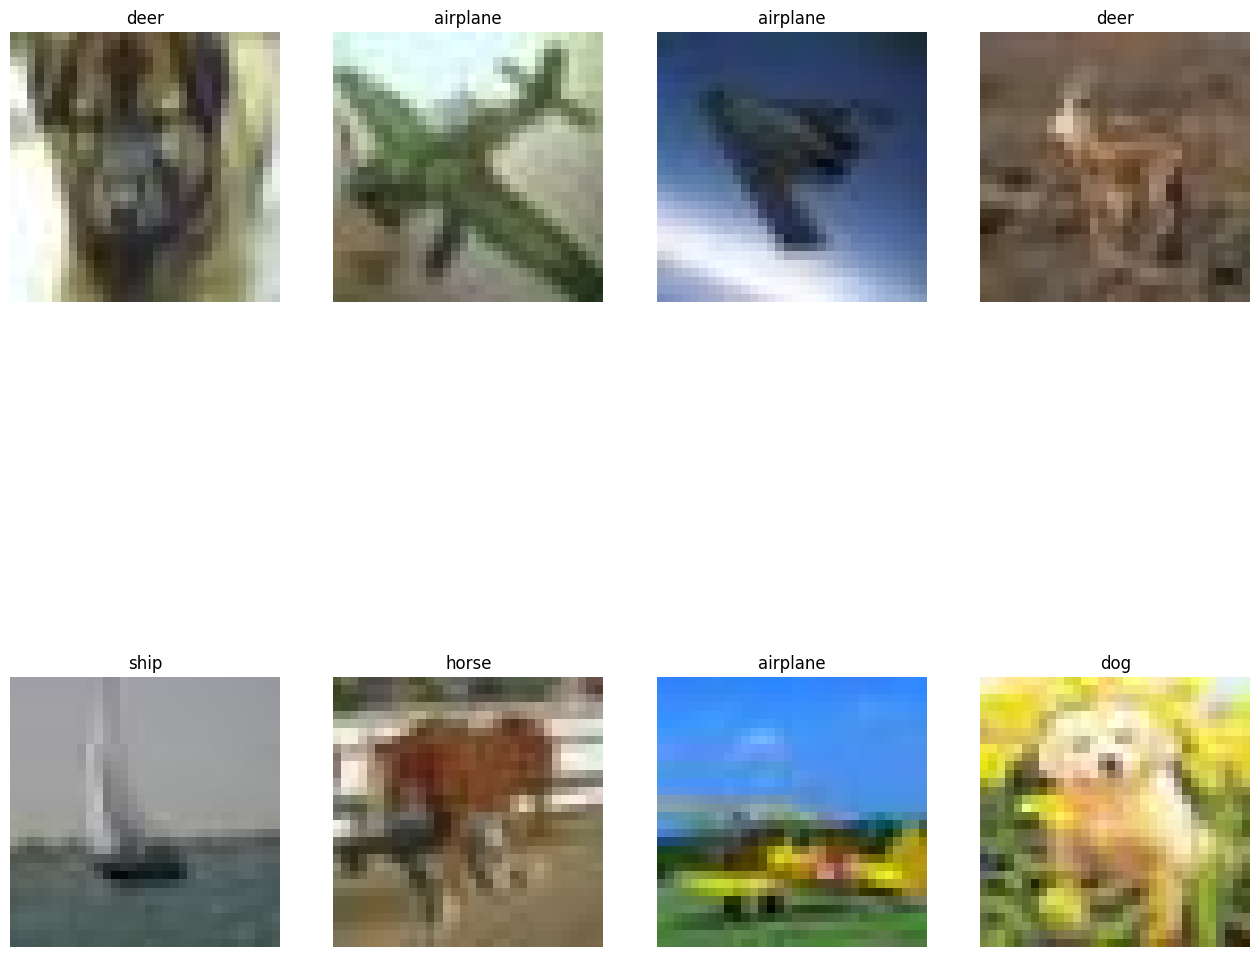

In [106]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(2, 4, i+1)                              #(4, 4, 2 * i + 1)
    plt.title(classes[:10][list_of_pred[i]])
    plt.imshow(image)
    plt.axis("off")

plt.subplots_adjust(hspace=0.1)
plt.show()

now, metrics

In [34]:
# groundability

def groundability(predictions, k):
    num_selected = (predictions < k).sum().item()
    groundability = num_selected / k
    return groundability

In [33]:
# functuality

def factuality(predictions, k):
    num_selected = (predictions < k).sum().item()
    factuality = num_selected / k
    return factuality

nowm with cifar10 concepts

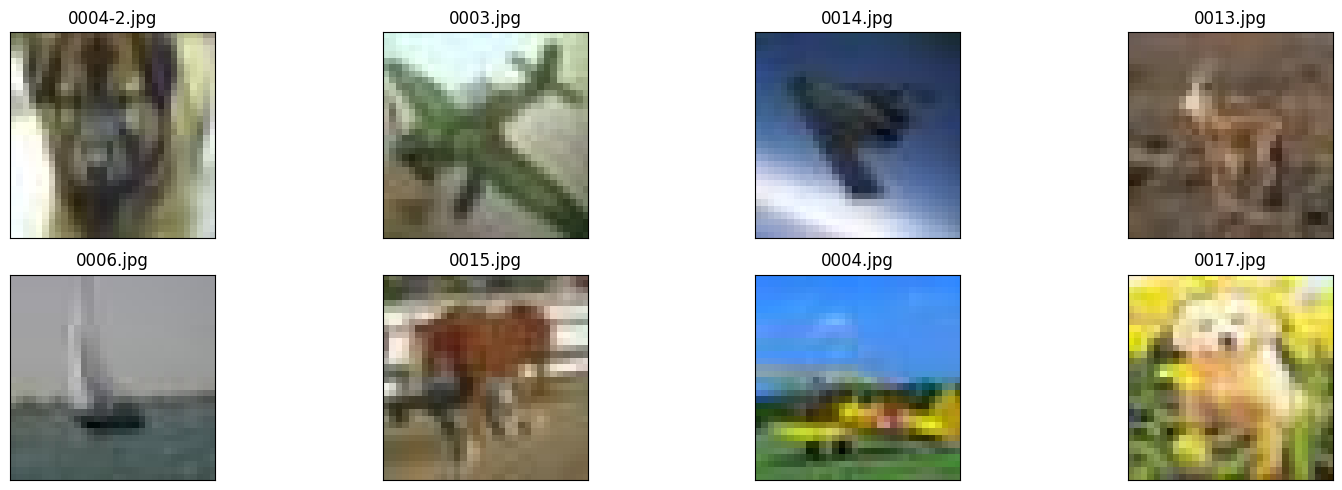

In [6]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [10]:
text_descriptions = []

with open("conceptnet_cifar10_filtered_new.txt", "r") as file:
  for line in file:
    text_descriptions.append(line.strip())

text_descriptions = remove_prefixes(text_descriptions)
text_descriptions = [x.lower() for x in text_descriptions]
print(text_descriptions)

['trunk', 'french person', 'tail', 'bigger type of car', 'bow and a stern', 'clutch', 'curious observer of mankind', 'drive train', 'form of transportation', 'good friend', 'heater', 'large machine with wings', 'mans best friend', 'nose', 'radiator', 'tire', 'vehicle type', 'vehicle with seats inside it', 'accelerator', 'adornment', 'air sac', 'amphibian', 'animal', 'antler', 'engine', 'oil pan', 'bay', 'beak', 'bigger than a car', 'bilge pump', 'bilge well', "bird's foot", 'black', 'bulkhead', 'bulwarks', 'bumper', 'cargo area', 'chap', "crow's nest", 'dark meat', 'davit', 'deck', 'domestic animal', 'emergency brakes', 'encolure', 'escape hatch', 'exhaust pipe', 'feather', 'fin', 'flag', 'fleas', 'forecastle', 'four legs', 'fun', 'funnel', 'furcula', 'fuselage', 'galley', 'gaskin', 'giblet', 'gossip', 'green', 'gymnastic apparatus', 'gyrostabilizer', 'hair', 'heavier than air', 'heavier-than-air craft', 'helm', 'hindquarters', 'hood', "horse's foot", 'horsemeat', 'hungry', 'landing ge

In [14]:
len(text_descriptions)

120

In [16]:
len(classes)

10

In [13]:
image_input = torch.tensor(np.stack(images))
image_encodings = clip_model.encode_image(image_input)
image_encodings = F.normalize(image_encodings)

In [17]:
label_encodings = F.normalize(clip_model.encode_text(tokenizer.tokenize(text_descriptions)))
image_labels_similarity = image_encodings @ label_encodings.T
image_labels_similarity.argmax(dim=1)

tensor([92, 56, 87, 92, 78, 92, 56, 92])

In [15]:
classes = []
with open("cifar10_classes.txt", "r") as file:
  for line in file:
    classes.append(line.strip())

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [46]:
n_classes = len(classes)
image_description_similarity = [None]*n_classes
image_description_similarity_cumulative = [None]*n_classes

In [28]:
for i, v in enumerate(classes):
        v = F.normalize(clip_model.encode_text(tokenizer.tokenize(v)))
        dot_product_matrix = image_encodings @ v.T
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

In [29]:
cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
predictions = cumulative_tensor.argmax(dim=1)
predictions

tensor([4, 0, 0, 4, 8, 7, 0, 5])

In [30]:
list_of_pred = torch.Tensor.tolist(predictions)

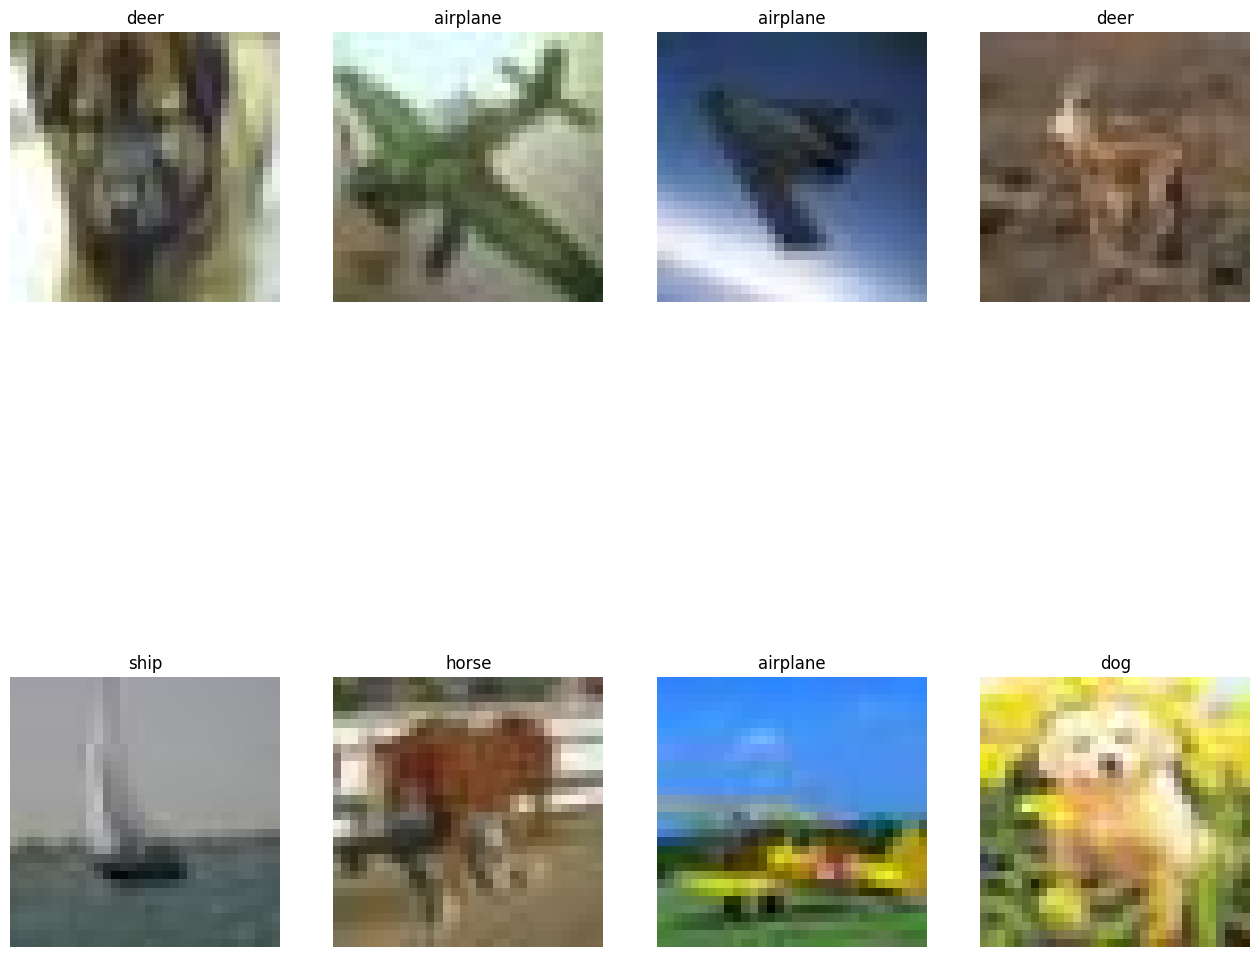

In [31]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(2, 4, i+1)                              #(4, 4, 2 * i + 1)
    plt.title(classes[list_of_pred[i]])
    plt.imshow(image)
    plt.axis("off")

plt.subplots_adjust(hspace=0.1)
plt.show()

In [39]:
list_of_pred

[4, 0, 0, 4, 8, 7, 0, 5]

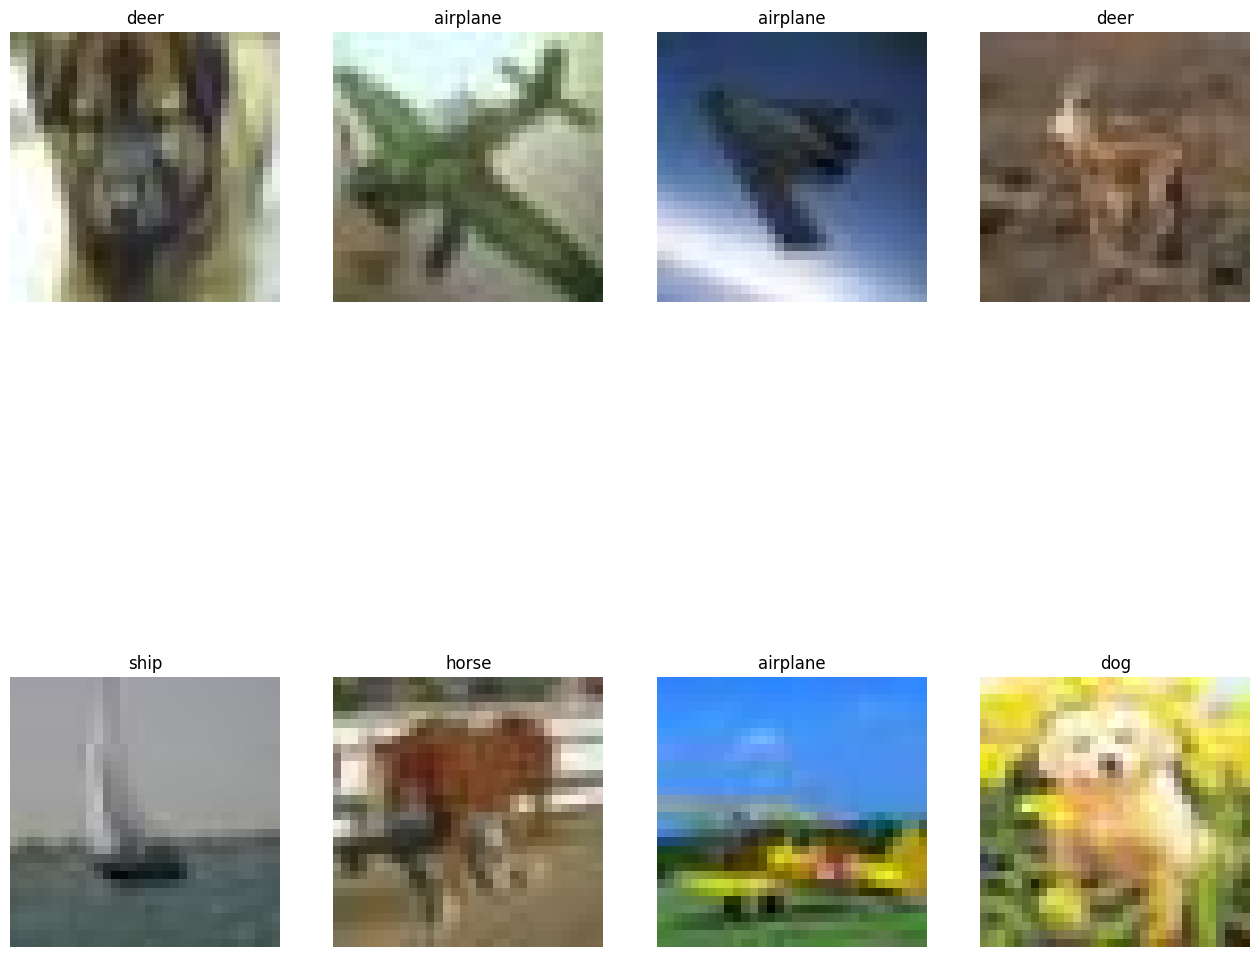

In [42]:
k = 10
factuality_scores = []
groundability_scores = []

'''for i, classname in enumerate(classes):
    factuality = factuality(list_of_pred[i], k)
    groundability = groundability(list_of_pred[i], k)

    factuality_scores.append(factuality)
    groundability_scores.append(groundability)
'''
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(2, 4, i+1)
    #plt.title(f"{classes[list_of_pred[i]]}\nFactuality: {factuality_scores[i]:.2f}\nGroundability: {groundability_scores[i]:.2f}")
    plt.title(classes[list_of_pred[i]])
    plt.imshow(image)
    plt.axis("off")

plt.subplots_adjust(hspace=0.1)
plt.show()

one more test

In [43]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.startswith("007")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")
    images.append(preprocess(image))
    original_images.append(image)

<Figure size 1600x500 with 0 Axes>

In [45]:
image_input = torch.tensor(np.stack(images))
image_encodings = clip_model.encode_image(image_input)
image_encodings = F.normalize(image_encodings)

In [47]:
for i, v in enumerate(classes):
        v = F.normalize(clip_model.encode_text(tokenizer.tokenize(v)))
        dot_product_matrix = image_encodings @ v.T
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

In [48]:
cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
predictions = cumulative_tensor.argmax(dim=1)
predictions

tensor([7, 7, 7, 7])